In [67]:
# using Pkg
# Pkg.activate("")

# # Packages that you need
# packages_to_install = ["MLDatasets", "Plots", "Statistics", "Distributions", "Random", "Flux", "Yao", "FLOYao", "PythonCall", "BenchmarkTools", "Dates", "FiniteDifferences"]

# for pkg in packages_to_install
#     Pkg.add(pkg)
# end

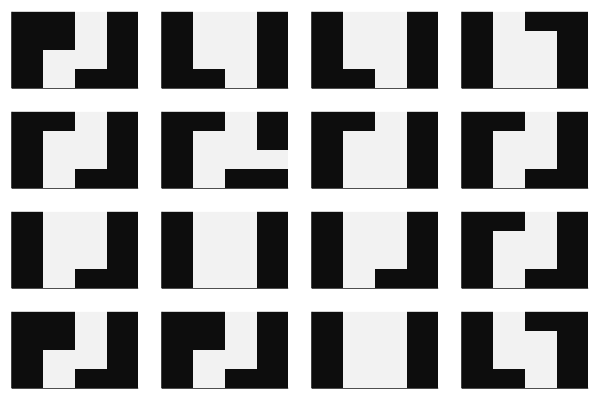

In [68]:
using MLDatasets
using Plots
using Statistics
using Distributions
using Random

train = 16 # Size of training dataset

digit = 1 # Digit to be learned
image_size = 28 # Size of image
compress_size = 4 # Size of compressed image

function compress(img, original, compress, max = true) #If max is false, then it does mean-convolution instead
    ratio = original ÷ compress
    compressed = zeros(compress, compress)
    a = []
    for i in 0:compress-1
        for j in 0:compress-1
            empty!(a)
            for p in 1:ratio
                for q in 1:ratio
                    push!(a, img[(ratio*i) + p, (ratio*j) + q])
                end
            end
            compressed[i+1, j+1] = max ? maximum(a) : mean(a)
        end
    end
    return compressed
end

train_set = MNIST(:train)
train_labels = MNIST(split=:train).targets

data_train = []
c = 1
trainstats = []
for _ in 1:train
    while train_labels[c] != digit
        c += 1
    end
    push!(data_train, compress(rotl90(train_set[c][1]), image_size, compress_size) .> 0.5)
    push!(trainstats, sum(compress(train_set[c][1], image_size, compress_size) .> 0.5))
    c += 1
end

plot([heatmap(x, color=:grays, colorbar = false, ticks = false) for x in data_train]...) #Is there any way to make this look nicer? use pythoncall and matplotlib i guess

In [69]:
using Yao
using Flux

N = compress_size^2 #Number of qubits

#Parameters are random (typically is N(0, sqrt(width)), not really sure how it's implemented)
d = Chain(Dense(N, 10, relu), Dense(10, 1, sigmoid)) 

nparams = sum(length, Flux.params(d))
println("Number of parameters in discriminator: $nparams")

layers = 1
g = chain(N)
for _ in 1:layers
    for i in 1:N-1
        push!(g, rot(kron(N, i => X, i+1 => X), 0.)) #Implemented using qiskit's definition (https://qiskit.org/documentation/stubs/qiskit.circuit.library.RXXGate.html)
    end
    # for i in 1:N-1
    #     push!(g, rot(kron(N, i => Y, i+1 => Y), 0.))
    # end
    for i in 1:N
        push!(g, put(N, i => Rz(0.)))
    end
end

nparams = nparameters(g)
println("Number of parameters in generator: $nparams")  
#dispatch!(g, :random)
dispatch!(g, rand(nparams).*2π)
println(parameters(g))

Number of parameters in discriminator: 181
Number of parameters in generator: 31
[0.6848071744299681, 2.8291723351078466, 3.8880422981966034, 1.0452389797191606, 1.9290723019516782, 1.892476838143939, 0.3769998301828346, 0.8709156194130866, 1.566414171540021, 0.13236914244083905, 1.587589030362165, 4.26182996354955, 3.7556015516576187, 5.408207486212387, 1.1177029855660563, 1.067452876128041, 2.613949949569268, 3.7056224062688927, 6.103316921609948, 5.752846782779727, 1.4438082332401883, 1.4891739120882153, 4.240234226942948, 3.443112488768078, 4.32451039702615, 5.807816919676919, 3.064301325441611, 0.7862290547767307, 4.321802558895583, 5.155328004402776, 3.4869692192379365]


μ: 6.5
σ: 0.9660917830792959
Bool[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

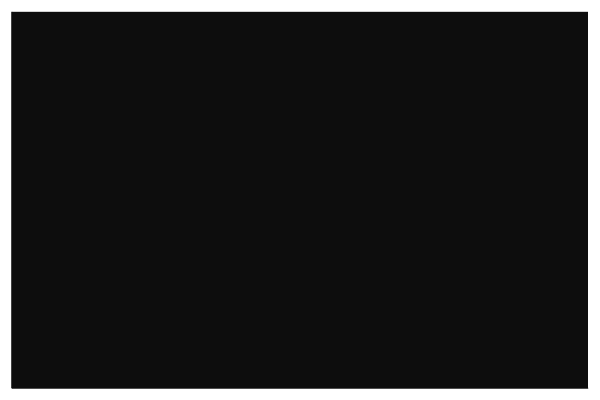

In [70]:
using FLOYao
using Random
using Distributions

mu = mean(trainstats)
sigma = std(trainstats)
println("μ: $mu")
println("σ: $sigma")
#dist = Normal(mu, sigma/20)
dist = Normal(mu, 1)

#ratio = rand(dist) / N
ratio = 0 #if ratio = 0 then pprior() is all 0s
function pprior() #For each square, probability ratio that it's white, where ratio ~ N(mean(data), std(data)) /  N; maybe we can vary pprior later?
    a = rand(N) .< ratio
    return FLOYao.product_state(Int.(a)) #Returns MajoranaReg; Prepares it to be sent through the generator 
end

pprior_example = rand(N) .< ratio
print(pprior_example)
heatmap(rotl90(reshape(pprior_example, compress_size, compress_size)) .> 0.5, color=:grays, colorbar = false, ticks = false)

In [71]:
using Flux: train!
using Yao
using FLOYao
using Statistics

function postprocess(g_output::Vector) #turns the output of reg |> g |> measure into an Int vector
    result = []
    for i in 1:N 
        push!(result, g_output[1][end - i + 1])
    end
    Int.(result)
end

samplemean_batch = 5000
dispatch!(g, rand(nparams).*2π)
function run_g(; theta = parameters(g), nbatch = samplemean_batch)
    dispatch!(g, theta)
    samples = []
    for i in 1:nbatch
        z = pprior() #MajoranaReg object
        result = z |> g |> measure |> postprocess
        if i == 1
            samples = result
        else
            samples = hcat(samples, result) #is this operation slow; on another note there has to be a better way to write this function right
        end
    end
    samples
end
#outputs an N * #samples matrix

function run_d_fake(samples)
    if size(samples)[1] != N #Require samples to be an N x #samples matrix
        println("Improper formatting of samples")
        return
    end
    samples |> d
end

function run_d_real() #Runs d on all training data
    samples = []
    for i in 1:train
        result = data_train[i] |> vec
        if i == 1
            samples = result
        else
            samples = hcat(samples, result)
        end
    end
    samples |> d
end

function gLoss(; theta = parameters(g), nbatch = samplemean_batch)
    dispatch!(g, theta)
    -mean(log.(run_d_fake(run_g(theta, nbatch))))
end

#Ideally... but how do u get gradients to go down? do we just not use flux train? tbh i'm ok with that but then i need to figure out how else to implement optimization stuff (maybe use python)
# function dLoss(nbatch = samplemean_batch)
#     real = mean(log.(run_d_real()))
#     fake = mean(log.(1 .- run_d_fake(run_g(nbatch))))
#     -(real + fake)
# end

#This is only formatted like this in order to use Flux.train!
#So maybe I shouldn't use it?
function dLoss(m, real, fake) #m is the discriminator, real is the actual data, fake is G(z) where z is sampled from pprior()
    -(log.(m(real)) + log.(1 .- m(fake))) |> first
end

gLoss()

1.1421204f0

In [72]:
# using Plots
# using Statistics

# p = []
# for _ in 1:500
#     push!(p, gLoss())
# end

# histogram(p, bins=20, xlabel="gLoss", ylabel="Frequency")

# #@time gLoss() #It's still decently spread out...

In [73]:
using Yao
using FLOYao

function parametershift_grad(theta = parameters(g)) #Shift parameters in-place
    l = nparameters(g)
    temp_params = theta
    temp_params[1] += π/2
    grad = zeros(l)
    for i in 1:l
        plus = 0
        minus = 0
        dispatch!(g, temp_params)
        plus = gLoss() #This is the problem
        temp_params[i] -= π
        dispatch!(g, temp_params)
        minus = gLoss()
        grad[i] = (plus - minus) / 2
        if i < l
            temp_params[i] += π/2
            temp_params[i+1] += π/2
        end
    end
    temp_params[l] += π/2
    dispatch!(g, temp_params)
    grad
end

#println(finitediff_grad())
#Computing gradients is slow and also I'm still getting different results for parametershift and finitediff
#parametershift prints very small numbers and finitediff prints very big numbers...

# for _ in 1:10
#     println(parametershift_grad()) #Should print similar numbers...
# end

parametershift_grad (generic function with 2 methods)

In [74]:
g_lr = 1
d_lr = 0.5

opt_flag = 1
if opt_flag == 1
    d_opt = Flux.setup(Adam(), d) 
elseif opt_flag == 2
    d_opt = Flux.setup(Descent(d_lr), d) #lol is this right
elseif opt_flag == 3
    d_opt = Flux.setup(SGD(), d) #yeah idk anymore
end

gLoss_values = []
dLoss_values = []
g_epochs = 50
d_epochs = 10
epochs = 10
batch = train

for i in 1:epochs
    t = time()
    for j in 1:g_epochs
        dispatch!(-, g, parametershift_grad() * g_lr)
        push!(gLoss_values, gLoss())
    end
    for j in 1:d_epochs
        real = []
        fake = []
        for m in 1:batch
            x = data_train[m] |> vec 
            push!(real, Int.(x))
            push!(fake, run_g(nbatch = 1))
        end
        data = collect(zip(real, fake)) 
        Flux.train!(dLoss, d, data, d_opt)
        s = 0
        for x in data
            s += dLoss(d, x[1], x[2])        
        end
        push!(dLoss_values, s / batch)
    end
    println("iteration $i done in: ", time() - t)
end

iteration 1 done in: 1509.2788519859314
iteration 2 done in: 

1479.29843211174


iteration 3 done in: 1480.1154110431671
iteration 4 done in: 

1485.6454899311066


iteration 5 done in: 1488.121593952179
iteration 6 done in: 

1492.32896900177


iteration 7 done in: 1500.0352928638458
iteration 8 done in: 

1486.1717381477356


iteration 9 done in: 1485.3114128112793
iteration 10 done in: 

1474.3794689178467


Generator loss


1.1223768
1.0943289
1.0641384
1.0375863
0.9996503
0.97188205
0.93949044
0.9031433
0.8696272
0.83522266
0.79846984
0.7672616
0.73778856
0.71090066
0.6848244
0.6577523
0.6390685
0.6213062
0.6087975
0.59692436
0.5822069
0.5701373
0.5627518
0.5538091
0.5496921
0.5404007
0.5347567
0.5278469
0.5234155
0.5184305
0.5133779
0.50978565
0.5040498
0.50284284
0.49829453
0.4968616
0.49426866
0.4925088
0.48885995
0.4877382
0.48396483
0.48325524
0.48226163
0.48114964
0.4794886
0.47734898
0.4762538
0.47621396
0.47432324
0.473424
1.2440524
1.224533
1.2044699
1.1748074
1.1385444
1.1021872
1.0486894
1.0045326
0.9627787
0.9169305
0.8906016
0.8626242
0.8443414
0.83068585
0.822234
0.81544816
0.8094062
0.8040427
0.8001544
0.794982
0.7918882
0.7897965
0.7862064
0.78130984
0.7771558
0.7743332
0.77090657
0.7646357
0.76341265
0.7571693
0.75495183
0.74961394
0.74452263
0.74043345
0.7361956
0.72925466
0.725167
0.7209306
0.71766955
0.71190304
0.7081541
0.70272005
0.6975834
0.6925327
0.68874073
0.6862586
0.6825659
0.

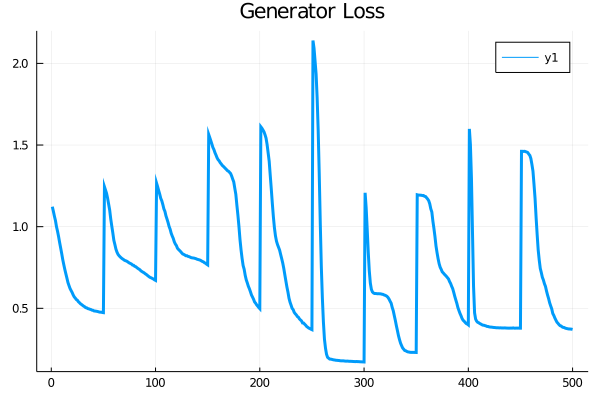

In [75]:
println("Generator loss")

#println(gLoss_values)
# for l in gLoss_values
#     println(l)
# end

plot(gLoss_values, title = "Generator Loss", linewidth=3)

Discriminator loss
1.7960036
1.6632724
1.5362849
1.4311157
1.3361199
1.2377267
1.138686
1.0803937
1.000162
0.9382079
1.2427493
1.1486375
1.0804975
1.0082014
0.9864587
0.9136975
0.8593237
0.7948413
0.7768628
0.7062764
0.9400431
0.8577437
0.8219395
0.74867713
0.71216583
0.64544487
0.61292696
0.5651811
0.51684594
0.47153717
1.041822
0.8867231
0.7892004
0.7198334
0.66896904
0.6220091
0.5776222
0.5376131
0.49542212
0.47006395
1.0675344
0.78714347
0.6984108
0.59420764
0.5197811
0.5366837
0.42238954
0.38977492
0.3445239
0.30466098
1.5784227
1.2334684
1.1577061
1.0519074
0.9949895
0.9572275
0.84845495
0.8674957
0.8285303
0.79350847
1.6649024
1.3733885
1.23375
1.1320727
1.0541143
0.9895369
0.9333165
0.8822758
0.83589023
0.79406536
1.2373594
1.0166295
0.89821374
0.8057774
0.7275609
0.70033056
0.609971
0.6056374
0.5248533
0.48264456
1.1201622
0.95749366
0.88164705
0.8169927
0.76317793
0.7197455
0.6813952
0.6466909
0.6151704
0.58649814
1.2562948
0.93657833
0.71945214
0.5716786
0.45188832
0.3712544

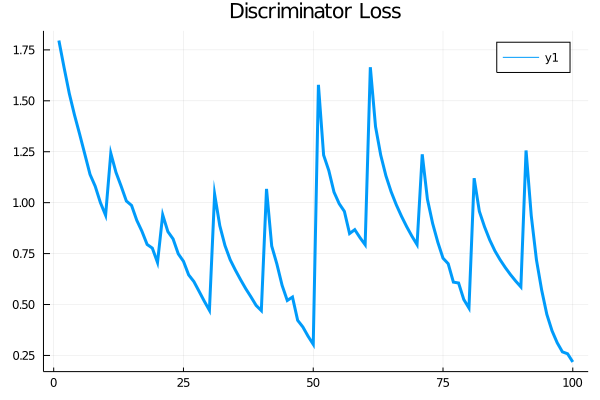

In [76]:
println("Discriminator loss")

# println(dLoss_values)
# for l in dLoss_values
#     println(l)
# end

plot(dLoss_values, title = "Discriminator Loss", linewidth=3)

In [77]:
#Testing the Discriminator

d_fake = first(run_d_fake(run_g(nbatch = 1)))
println("fake data: $d_fake") #Should print a number close to 0

index = rand(1:train)
d_real = data_train[index] |> vec |> d |> first
println("real data: $d_real") #Should print a number close to 1

fake data: 0.07588335
real data: 0.9229746


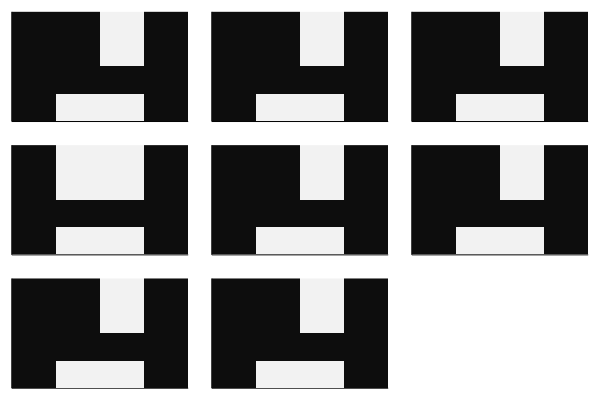

In [170]:
#Testing the Generator

nsamples = 8
samples = run_g(nbatch = nsamples)
d = Int.(vec(data_train[1]))
samples = hcat(samples, d)
plot([heatmap(reshape(samples[:, i], compress_size, compress_size), color=:grays, colorbar = false, ticks = false) for i in 1:(nsamples+1)]...)